<a href="https://colab.research.google.com/github/devlai23/MusicVision/blob/master/music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [188]:
pip install anvil.uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [189]:
import anvil.server
anvil.server.connect("XXZ2FXE766LCYN4IFEOKZN5A-WJ3GZS5CJOP55SZU")

In [190]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [191]:
import warnings
warnings.simplefilter('ignore')

In [192]:
import fastai as fa
from fastai.vision import *

In [193]:
import os
from pathlib import *
import pandas as pd

In [194]:
INPUT = Path("Kaggle")
os.listdir(INPUT)

['data2.csv', 'data1.csv']

In [195]:
test_df = pd.read_csv(INPUT/"data1.csv")
test_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [196]:
train_df = pd.read_csv(INPUT/"data2.csv")
train_df.head(3)

,label,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,Eight,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,Eight,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,Eight,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [197]:
TRAIN = Path("train")
TEST = Path("test")

In [198]:
try:
    os.makedirs(TEST)
except:
    pass

In [199]:
import numpy as np

from PIL import Image

def save(note, filepath):
    note = note.reshape(64,64)
    note = note.astype(np.uint8)

    img = Image.fromarray(note)
    img.save(filepath)

In [200]:
# save testing images
for index, note in test_df.iterrows():

    folder = TEST
    filename = f"{index}.jpg"
    filepath = folder/filename
    
    note = note.values
    
    save(note, filepath)

In [201]:
# save training images
for index, row in train_df.iterrows():
      label,note = row[0], row[1:]
      
      folder = TRAIN/str(label)
      filename = f"{index}.jpg"
      filepath = folder/filename
      
      note = note.values
      
      save(note, filepath)

In [202]:
tfms = fa.vision.get_transforms(do_flip=False)

In [203]:
print('test:',TEST)
print('train:', TRAIN)
print(type(TEST))

test: test
train: train
<class 'pathlib.PosixPath'>


In [204]:
data = fa.vision.ImageDataBunch.from_folder(
    path = ("train"),
    test = ("test"),
    valid_pct = 0.2,
    bs = 16,
    size = 28,
    #num_workers = 0,
    ds_tfms = tfms
)

In [205]:
mnist_stats

([0.131], [0.308])

In [206]:
data.normalize(mnist_stats)

ImageDataBunch;

Train: LabelList (1996 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
Half,Half,Half,Half,Half
Path: train;

Valid: LabelList (498 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
Half,Quarter,Whole,Quarter,Eight
Path: train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train

In [207]:
print(data.classes)

['Eight', 'Half', 'Quarter', 'Sixteenth', 'Whole']


In [208]:
learn = cnn_learner(data, base_arch=models.resnet18, metrics=accuracy, model_dir="/tmp/models", callback_fns=ShowGraph)

In [209]:
# finding optimal learning rate, accuracy 90%+
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03
Min loss divided by 10: 9.12E-04


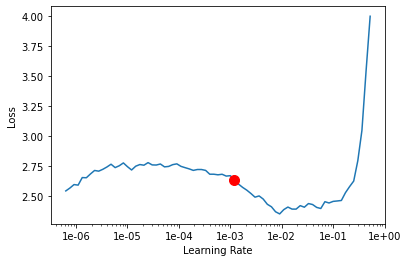

In [210]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.277505,0.782415,0.678715,00:05
1,0.997014,0.600939,0.781124,00:05
2,0.824317,0.472637,0.807229,00:05
3,0.746272,0.337909,0.873494,00:05
4,0.553961,0.326625,0.881526,00:04
5,0.518880,0.269951,0.905622,00:04
6,0.480249,0.238632,0.907631,00:05


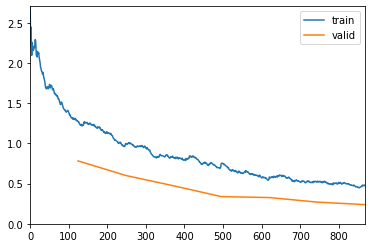

In [211]:
learn.fit(7, 1e-3)

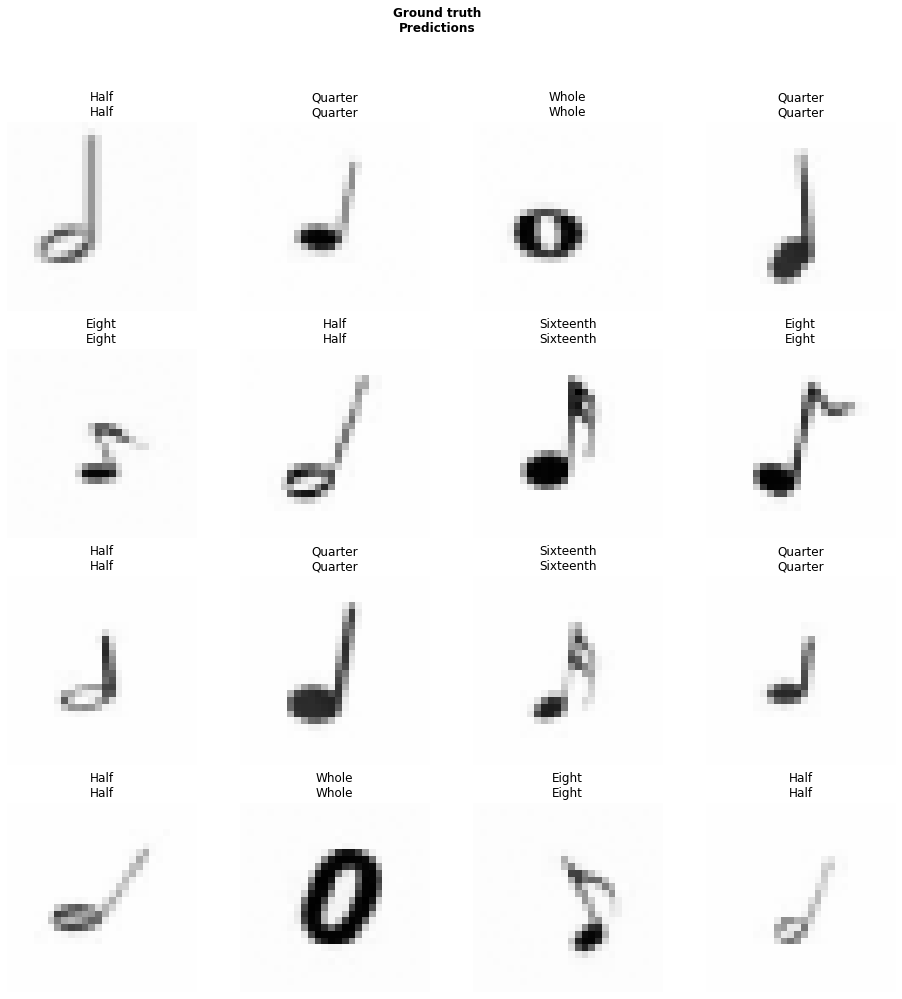

In [212]:
learn.show_results()

In [213]:
interp = ClassificationInterpretation.from_learner(learn)

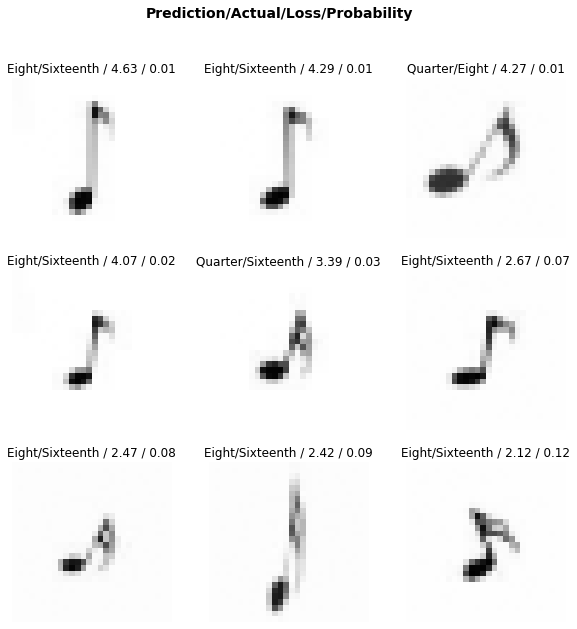

In [214]:
interp.plot_top_losses(9, figsize=(10, 10))

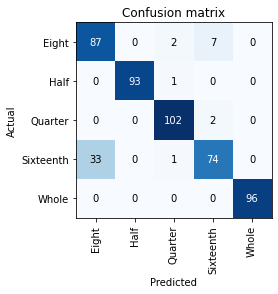

In [215]:
interp.plot_confusion_matrix()

In [216]:
index = 0

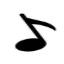

In [217]:
files = get_image_files("test")
open_image(files[index])

In [218]:
learn.predict(open_image(files[index]))

(Category tensor(0),
 tensor(0),
 tensor([9.4694e-01, 2.6869e-04, 3.3724e-04, 4.1392e-02, 1.1066e-02]))

In [219]:
if (learn.predict(open_image(files[index]))[1] == tensor(0)):
  print("Eighth")
elif (learn.predict(open_image(files[index]))[1] == tensor(1)):
  print("Half")
elif (learn.predict(open_image(files[index]))[1] == tensor(2)):
  print("Quarter")
elif (learn.predict(open_image(files[index]))[1] == tensor(3)):
  print("Sixteenth")
elif (learn.predict(open_image(files[index]))[1] == tensor(4)):
  print("Whole")

Eighth


In [220]:
@anvil.server.callable
def predict(image):
  learn.predict(image)
anvil.server.wait_forever()

KeyboardInterrupt: ignored